# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Matias Aniñir
+ Samuel Garrido

**Correos Electrónicos:**

+ mat.aninir@duocuc.cl
+ sam.garrido@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.10

#Introducción

##Descripción del problema y objetivos

El proyecto se centra en la clasificación automática de imágenes que contienen dígitos manuscritos. El objetivo principal es diseñar e implementar una red neuronal multicapa (MLP) capaz de reconocer correctamente cada número y maximizar métricas de desempeño. Para ello, se partirá de un modelo base y, mediante un proceso de experimentación controlada, se evaluará sistemáticamente cómo cada ajuste de hiperparámetro afecta la capacidad de generalización del clasificador.

##Justificación del enfoque

Se ha optado por emplear un perceptrón multicapa (MLP) dado su equilibrio entre sencillez y eficacia en problemas de reconocimiento de dígitos. La implementación se realizará con TensorFlow/Keras, utilizando optimizadores modernos (por ejemplo, Adam y SGD) y técnicas de regularización como dropout. La metodología de trabajo consistirá en partir de un modelo base y, en cada iteración, modificar únicamente un parámetro para aislar su impacto en el rendimiento. La configuración que obtenga el mejor desempeño en cada experimento se mantendrá como punto de partida para la siguiente prueba, repitiendo este ciclo hasta converger en la arquitectura y los valores de hiperparámetros óptimos.

# Carga de datos

En esta sección se muestra cómo descargar y cargar el conjunto de datos MNIST, que contiene imágenes de dígitos manuscritos y sus etiquetas. Se define una función para leer tanto las imágenes como las etiquetas desde los archivos comprimidos, y luego se normalizan y codifican adecuadamente.


In [ ]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-13 17:02:22--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.12.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  30.4MB/s    in 0.3s    

2025-04-13 17:02:22 (30.4 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-13 17:02:22--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.12.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [app

In [ ]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 10 13:37 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [ ]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga y Preprocesamiento de Datos

##Preprocesamiento

In [ ]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La estructura del preprocesamiento aplicado se justifica en función de los requerimientos del modelo MLP y de buenas prácticas en Deep Learning. En primer lugar, el aplanado de las imágenes es necesario ya que el MLP requiere vectores unidimensionales como entrada; por ello, cada imagen de 28×28 píxeles se transforma en un vector de 784 componentes. En segundo lugar, se aplica una normalización dividiendo los valores de los píxeles por 255.0, lo cual reescala la información al rango [0,1]. Esta transformación favorece una convergencia más rápida durante el entrenamiento y previene problemas de saturación en las funciones de activación. Finalmente, se utiliza codificación one-hot para representar las etiquetas de clase, lo que permite calcular adecuadamente la función de pérdida categorical_crossentropy, comúnmente utilizada en tareas de clasificación multiclase.

##Muestra imágenes

Se visualizan ejemplos aleatorios y se examina la distribución de clases para entender mejor el conjunto de datos.

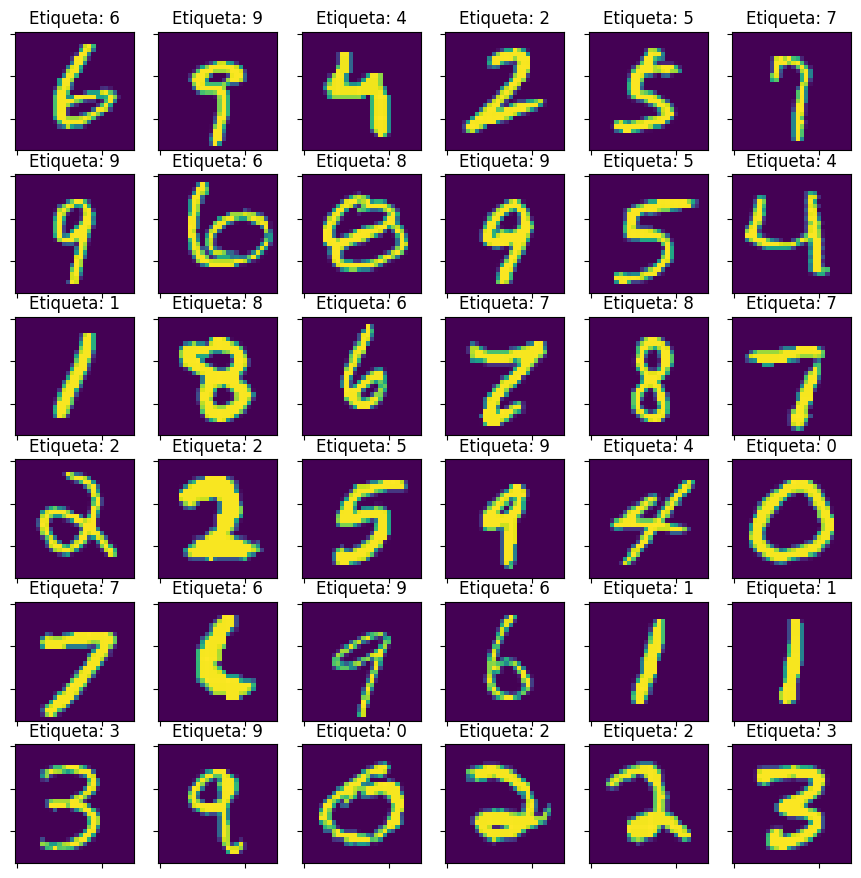

In [ ]:
H = 6
W = 6

fig, axs = plt.subplots(H, W, figsize=(1.8*H,1.8*W))
for i in range(H):
  for j in range(W):
    ex = np.random.randint(len(X_train))
    label = np.argmax(y_train[ex])
    axs[i,j].set_title("Etiqueta: " + str(label))
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(X_train[ex].reshape(28, 28))

In [ ]:
# Obtener la cantidad de cada clase
class_counts = pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index()

# Calcular el porcentaje de cada clase
class_percentages = round((class_counts / len(y_train)) * 100, 1)

# Crear una tabla con la información
data = {'Cantidad': class_counts, 'Porcentaje': class_percentages}
df = pd.DataFrame(data)
df.index.name = 'Clase'

# Mostrar la tabla
display(df)

Del análisis exploratorio se desprenden varias observaciones relevantes sobre el conjunto de datos. El set de entrenamiento está compuesto por 60 000 imágenes, mientras que el set de prueba contiene 10 000, lo que proporciona una base sólida para el entrenamiento y la evaluación del modelo. En cuanto a la distribución de clases, los dígitos del 0 al 9 se encuentran representados de manera prácticamente uniforme, con una proporción cercana al 10 % para cada clase, lo que garantiza un equilibrio que evita sesgos en el aprendizaje. Además, las muestras visualizadas evidencian una notable variabilidad en cuanto al tamaño, grosor del trazo y estilo de escritura, lo que representa un desafío adicional para el modelo, al tiempo que incrementa su capacidad de generalización si logra un buen desempeño.

Al observar la matriz de ejemplos aleatorios, se ha identificado que el dígito "1" suele estar representado mediante una línea recta simple. Esta representación homogénea podría limitar la capacidad del modelo para generalizar correctamente cuando se le presenten variantes del número "1" dibujadas con mayor complejidad o estilo diferente, como aquellos trazos con serifas o inclinaciones. Esta falta de diversidad en la representación específica de dicha clase podría afectar negativamente el rendimiento del modelo frente a casos no vistos durante el entrenamiento.

#Definición del Modelo (Arquitectura MLP)

##Diseño de la red

Para abordar la tarea de clasificación de imágenes de dígitos manuscritos, se ha definido una arquitectura basada en una red neuronal multicapa (MLP) compuesta por seis capas en total, incluyendo la capa de entrada y la de salida. La arquitectura se inicia con una capa de entrada que recibe vectores de 784 características (provenientes del aplanado de imágenes 28×28), seguida por cuatro capas ocultas densas con 256, 128, 64 y 32 neuronas respectivamente. Finalmente, se incorpora una capa de salida con 10 neuronas, correspondiente a las 10 clases posibles del dataset (dígitos del 0 al 9).

La función de activación empleada en las capas ocultas es `ReLU` (Rectified Linear Unit), debido a su eficiencia computacional y su capacidad para mitigar el problema del desvanecimiento del gradiente, favoreciendo una convergencia más rápida y estable. En la capa de salida se utiliza la función `softmax`, la cual permite interpretar los valores de salida como probabilidades asociadas a cada clase.

En cuanto a los optimizadores, se han considerado tres alternativas: `Adam`, `SGD`, y `SGD con momentum`. `Adam` se ha seleccionado como uno de los candidatos principales debido a su capacidad para adaptar automáticamente la tasa de aprendizaje de cada parámetro, acelerando la convergencia y ofreciendo buen rendimiento en una amplia variedad de problemas. Por su parte, `SGD` (Stochastic Gradient Descent) representa una alternativa clásica y robusta, que aunque más sensible a la configuración de hiperparámetros, puede ofrecer buenos resultados si se ajusta adecuadamente. Finalmente, la variante `SGD con momentum` ha sido incorporada debido a su capacidad para suavizar oscilaciones y acelerar el descenso en direcciones consistentes, mejorando así la eficiencia del entrenamiento.

##Funciones de activación y de error

Como función de activación principal se ha utilizado `ReLU`, que consiste en transformar cualquier valor negativo a cero y mantener los positivos sin alteración. Esta función es especialmente útil en redes profundas porque permite una propagación eficiente del gradiente y reduce el riesgo de saturación. Adicionalmente, se ha incluido la función `sigmoide` en algunas pruebas, con el objetivo de comparar su rendimiento, tal como exige la rúbrica. A pesar de su limitada aplicabilidad en redes profundas debido al problema del desvanecimiento del gradiente, la función sigmoide resulta útil para observar cómo varía la convergencia del modelo frente a funciones más modernas como `ReLU`.

Respecto a la función de pérdida, se ha utilizado `categorical_crossentropy`, ya que es la más adecuada para problemas de clasificación multiclase cuando las etiquetas están codificadas en formato `one-hot`, como en el presente caso. Esta función mide la disimilitud entre la distribución de probabilidad predicha por el modelo y la distribución real, penalizando con mayor fuerza las predicciones incorrectas. Adicionalmente, se ha incorporado la función `CategoricalFocalCrossentropy` con fines comparativos. Esta variante introduce un término de ponderación que reduce el impacto de las clases bien clasificadas y focaliza el aprendizaje en aquellas muestras más difíciles de predecir, lo que puede ser especialmente útil en escenarios con cierto grado de desbalance o cuando se desea fortalecer la capacidad del modelo para manejar ejemplos complejos. La comparación entre ambas funciones de pérdida permitirá analizar su impacto sobre la precisión, robustez y capacidad de generalización del modelo.

##Incorporación de técnicas de optimización

Para mejorar la capacidad de generalización del modelo y mitigar el sobreajuste, se ha incorporado la técnica de regularización dropout. Esta técnica consiste en desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que fuerza a la red a no depender excesivamente de nodos específicos y a aprender representaciones más robustas. Al reducir la co-adaptación entre neuronas, el dropout ayuda a mejorar el rendimiento en datos no vistos, especialmente en redes profundas. Este enfoque se integrará en distintas capas ocultas y se evaluará su impacto a través de experimentos comparativos con y sin su aplicación.

##Tabla resumen

A continuación se presenta la tabla resumen de las arquitecturas de prueba utilizadas durante el proceso experimental. En ella se detallan las distintas configuraciones evaluadas, destacando los cambios realizados en cada iteración. Las variables modificadas corresponden a los principales componentes que influyen en el rendimiento de una red neuronal, y se han ajustado de manera individual para asegurar un análisis controlado. Entre los elementos considerados se incluyen: el optimizador, la cantidad de épocas, el tamaño del batch, la función de activación, el uso o no de dropout, el número de capas, la función de salida, la tasa de aprendizaje y la función de pérdida. Esta estrategia permite observar con claridad el impacto que tiene cada parámetro sobre el desempeño del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Baseline    | Adam            |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 1    | **`SGD`**       |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 2    |**`SGD con Momentum`**|5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 3    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | 0 |**`CategoricalFocalCrossentropy`**|
| Cambio 4    | SGD con Momentum|5      |32          |relu         |0        |6           | **`sigmoid`** | 0 |categorical_crossentropy|
| Cambio 5    | SGD con Momentum|5      |32          |**`sigmoid`**      |0        |6           | softmax |0| categorical_crossentropy|
| Cambio 6    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | **`0.01`**| categorical_crossentropy|
| Cambio 7    | SGD con Momentum|**`10`**      |32          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 8    | SGD con Momentum|10      |**`64`**          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 9    | SGD con Momentum|10      |64          |relu         |0        |`8`           | softmax |0.01| categorical_crossentropy|
| Cambio 10    | SGD con Momentum|**`20`**      |64          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 11    | SGD con Momentum|20      |64          |relu         |**`0.2`**        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 12    | SGD con Momentum|20      |64          |relu         |**`0.4`**        |6           | softmax |0.01| categorical_crossentropy|

##Metricas a utilizar

En este proyecto se han considerado diversas métricas para evaluar el desempeño del modelo de clasificación, con el objetivo de obtener una visión completa de su rendimiento. Las métricas utilizadas son accuracy, precision y recall, las cuales permiten analizar desde diferentes perspectivas la calidad de las predicciones realizadas.

La accuracy representa la proporción de predicciones correctas respecto al total de muestras evaluadas. Es una métrica global que resulta útil cuando las clases están balanceadas, como es el caso del dataset MNIST. La precision, por su parte, mide la proporción de verdaderos positivos entre todas las predicciones positivas realizadas por el modelo, lo que permite evaluar cuán precisas son las predicciones para cada clase. En tanto, la recall (o sensibilidad) indica la proporción de verdaderos positivos detectados respecto al total real de esa clase, lo que refleja la capacidad del modelo para identificar correctamente los ejemplos pertenecientes a cada categoría.

En cuanto a la métrica F1-score, esta representa una media armónica entre la precision y el recall, y se utiliza especialmente en escenarios con desequilibrios importantes entre clases. Sin embargo, dado que el conjunto de datos utilizado presenta una distribución equitativa de clases y se dispone de un volumen considerable de datos para entrenar y validar, se ha decidido prescindir de esta métrica en esta etapa. La evaluación mediante accuracy, precision y recall resulta suficiente y más interpretativa para los objetivos planteados, evitando redundancia en el análisis de resultados.










#Entrenamiento y Ajuste de Hiperparámetros

Para todos los modelos construidos en el presente proyecto, se seguirá un procedimiento común que incluye tres etapas fundamentales: la definición de la arquitectura, la compilación del modelo y su posterior entrenamiento. Durante el proceso de entrenamiento, se utilizará de forma constante el parámetro `validation_data=(X_test, y_test)` con el propósito de monitorear el comportamiento del modelo frente a datos no vistos y así detectar posibles casos de overfitting o underfitting.

El overfitting se produce cuando el modelo aprende excesivamente los patrones del conjunto de entrenamiento, incluyendo ruido o detalles irrelevantes, lo que conlleva a un excelente rendimiento en los datos de entrenamiento pero a una pobre generalización en los datos de validación o prueba. Por el contrario, el underfitting ocurre cuando el modelo no logra capturar los patrones subyacentes del problema, obteniendo un bajo rendimiento tanto en los datos de entrenamiento como en los de prueba. Ambas situaciones son indeseables: el overfitting impide que el modelo sea útil en situaciones reales con nuevos datos, mientras que el underfitting indica una capacidad insuficiente del modelo para aprender el problema.

Se determinó que la variable `M` representa la cantidad de ejemplos en el conjunto de entrenamiento, equivalente a 60.000 muestras en MNIST. La variable `N` indica el número de características por ejemplo, correspondientes a 784 pixeles (28x28) que han sido previamente aplanados. Por otro lado, `C` representa la cantidad de clases de salida, en este caso 10, correspondientes a los dígitos del 0 al 9.

In [ ]:
# Cantidad de ejemplos, neuronas de entradas y neuronas de salida
M = X_train.shape[0]
N = X_train.shape[1]
C = y_train.shape[1]

print(M,N,C)

Se definieron cinco capas ocultas con la siguiente configuración de unidades:

In [ ]:
# Definición de tamaño de capas escondidas
h1 = 256
h2 = 128
h3 = 64
h4 = 32
h5 = 16

Se optó por una estructura de tipo "embudo" o decreciente, una práctica común en redes densas para ir reduciendo progresivamente la dimensionalidad de las representaciones intermedias. Esta forma de diseño ayuda al modelo a abstraer características relevantes de manera jerárquica, al mismo tiempo que reduce la complejidad computacional y el riesgo de sobreajuste.

Antes del entrenamiento, se fijaron semillas aleatorias tanto para NumPy como para TensorFlow:

In [ ]:
# semillas
np.random.seed(42)
tf.random.set_seed(42)

Establecer semillas garantiza la reproducibilidad de los resultados. Dado que el entrenamiento de modelos de Deep Learning involucra operaciones estocásticas (como inicialización de pesos y selección de batches), es crucial asegurar que los mismos parámetros conduzcan a los mismos resultados si se vuelve a ejecutar el experimento. Esto es especialmente importante en comparativos.

## Constucción modelo base

El modelo base establece la configuración inicial del modelo de red neuronal. Se define una arquitectura de red neuronal multicapa (MLP) con cuatro capas ocultas, utilizando la función de activación `ReLU` en cada una de ellas. La capa de salida utiliza la función `softmax` para obtener probabilidades para cada clase de dígitos (0-9).

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Baseline    | Adam            |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_base = keras.Sequential(name = "Baseline")
red_base.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_base.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_base.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_base.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_base.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_base.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_base.summary()

Para el entrenamiento, se utiliza el optimizador `Adam`, que es un algoritmo
adaptativo que ajusta automáticamente la tasa de aprendizaje para cada parámetro, lo que facilita el proceso de entrenamiento. La función de pérdida utilizada es `CategoricalCrossentropy`, adecuada para problemas de clasificación multiclase con etiquetas one-hot encoded.

In [ ]:
red_base.compile(
    loss = keras.losses.CategoricalCrossentropy(), # Función de perdida CategoricalCrossentropy
    optimizer = keras.optimizers.Adam(), # Optimizador Adam
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

El modelo se entrena durante `5 épocas`, utilizando un tamaño de `batch de 32`. Durante el entrenamiento, se monitoriza el rendimiento del modelo en un conjunto de datos de `validación (X_test, y_test)` para evaluar su capacidad de generalización y evitar el sobreajuste esto se aplica para todas las redes.

In [ ]:
# Entranamiento de la red
historial_adam = red_base.fit(
    X_train, y_train,
    epochs=5, # 5 Épocas
    batch_size=32, # 32 de batch_size
    validation_data=(X_test,y_test),
    verbose = 1
)

## Cambio 1

En el primer cambio, se mantuvo la misma arquitectura y todos los hiperparámetros del modelo Baseline, pero se reemplazó el optimizador Adam por SGD (Stochastic Gradient Descent) sin momentum. Esta modificación busca comparar el desempeño entre un optimizador adaptativo moderno como Adam y una versión clásica como SGD, que requiere un ajuste más fino de sus parámetros pero puede ofrecer un aprendizaje más estable en ciertos casos.

La función de pérdida y la activación de cada capa permanecieron sin cambios. El modelo se entrenó bajo las mismas condiciones: 5 épocas, batch size de 32, y conjunto de validación para monitorear la generalización. Esta comparación inicial establece una base para evaluar el efecto de incorporar mejoras al optimizador clásico en los siguientes experimentos.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 1    | **`SGD`**       |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_1 = keras.Sequential(name = "Cambio_1")
red_cambio_1.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_1.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_1.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_1.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_1.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_1.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_1.summary()

In [ ]:
red_cambio_1.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(), # Cambio de optimizador
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_sgd = red_cambio_1.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Función para Comparación de Métricas

In [ ]:
def comparar_metricas_modelos(historiales, nombres_modelos, modelo1, modelo2):
    """
    Compara las métricas de dos modelos específicos en una tabla.

    Args:
        historiales: Una lista de historiales de entrenamiento para cada modelo.
        nombres_modelos: Una lista de nombres de modelos (para las etiquetas de las filas).
        modelo1: Nombre del primer modelo a comparar.
        modelo2: Nombre del segundo modelo a comparar.

    Returns:
        Un DataFrame de Pandas que contiene las métricas de los dos modelos especificados.
    """

    # Obtener los índices de los modelos en las listas
    indice_modelo1 = nombres_modelos.index(modelo1)
    indice_modelo2 = nombres_modelos.index(modelo2)

    # Extraer las métricas de los modelos seleccionados
    metricas = []
    for i in [indice_modelo1, indice_modelo2]:
        historial = historiales[i]
        nombre_modelo = nombres_modelos[i]
        perdida = historial.history['loss'][-1]
        accuracy = historial.history['accuracy'][-1]
        val_perdida = historial.history['val_loss'][-1]
        val_accuracy = historial.history['val_accuracy'][-1]

        # Check if 'recall' is in history, otherwise use None
        recall = historial.history.get('recall', [None])[-1]
        val_recall = historial.history.get('val_recall', [None])[-1]

        # Check if 'precision' is in history, otherwise use None
        precision = historial.history.get('precision', [None])[-1]
        val_precision = historial.history.get('val_precision', [None])[-1]

        metricas.append([nombre_modelo, perdida, val_perdida, accuracy, val_accuracy, recall, val_recall, precision, val_precision])

    # Crear el DataFrame de Pandas
    # Se agregaron las columnas faltantes: 'Recall', 'Val_Recall', 'Precision', 'Val_Precision'
    df_metricas = pd.DataFrame(metricas, columns=['Modelo', 'Pérdida', 'Pérdida de Validación', 'Accuracy', 'Accuracy de Validación', 'Recall', 'Val_Recall', 'Precision', 'Val_Precision'])
    return df_metricas

Esta lista ejecutarla al final, para obtener todos los resultados

In [ ]:
# Lista de historiales de entrenamiento para cada modelo
historiales = [historial_adam, historial_sgd, historial_cambio2, historial_cambio3, historial_cambio4,
             historial_cambio5, historial_cambio6, historial_cambio7, historial_cambio8, historial_cambio9,
             historial_cambio10, historial_cambio11, historial_cambio12]

In [ ]:
nombres_modelos = ['Baseline', 'Cambio_1', 'Cambio_2', 'Cambio_3', 'Cambio_4',
           'Cambio_5', 'Cambio_6', 'Cambio_7', 'Cambio_8', 'Cambio_9',
           'Cambio_10', 'Cambio_11', 'Cambio_12']

## Comparación

In [ ]:
# Comparar las métricas de 'Baseline' y 'Cambio_1'
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Baseline', 'Cambio_1')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
def comparar_modelos(historial_base, historial_modificado, nombre_base='Modelo Base', nombre_modificado='Modelo Modificado'):
  """
  Genera gráficos de comparación de accuracy y pérdida entre dos modelos.

  Args:
    historial_base: Historial de entrenamiento del modelo base (obtenido con model.fit).
    historial_modificado: Historial de entrenamiento del modelo modificado.
    nombre_base: Nombre del modelo base para la leyenda del gráfico.
    nombre_modificado: Nombre del modelo modificado para la leyenda del gráfico.
  """

  fig, axs = plt.subplots(1, 2, figsize=(16, 6))

  # Gráfico de Pérdida
  axs[0].plot(historial_base.history['loss'], label=f'Pérdida {nombre_base} (Entrenamiento)')
  axs[0].plot(historial_base.history['val_loss'], label=f'Pérdida {nombre_base} (Validación)')
  axs[0].plot(historial_modificado.history['loss'], label=f'Pérdida {nombre_modificado} (Entrenamiento)')
  axs[0].plot(historial_modificado.history['val_loss'], label=f'Pérdida {nombre_modificado} (Validación)')
  axs[0].set_title('Comparación de Pérdida')
  axs[0].set_ylabel('Pérdida')
  axs[0].set_xlabel('Época')
  axs[0].legend(loc='upper right')

  # Gráfico de Precisión (Accuracy)
  axs[1].plot(historial_base.history['accuracy'], label=f'Precisión {nombre_base} (Entrenamiento)')
  axs[1].plot(historial_base.history['val_accuracy'], label=f'Precisión {nombre_base} (Validación)')
  axs[1].plot(historial_modificado.history['accuracy'], label=f'Precisión {nombre_modificado} (Entrenamiento)')
  axs[1].plot(historial_modificado.history['val_accuracy'], label=f'Precisión {nombre_modificado} (Validación)')
  axs[1].set_title('Comparación de Precisión')
  axs[1].set_ylabel('Precisión')
  axs[1].set_xlabel('Época')
  axs[1].legend(loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
# Comparar el modelo base (Adam) con el modelo modificado (SGD)
comparar_modelos(historial_adam, historial_sgd, 'Adam', 'SGD')

## Cambio 2

En el segundo experimento, se mantiene el uso del optimizador SGD, pero se le incorpora momentum con valor 0.9. Esta técnica introduce un componente de memoria que acumula gradientes pasados para suavizar las oscilaciones y acelerar la convergencia en direcciones consistentes. La inclusión de momentum busca mejorar el rendimiento de SGD, especialmente en superficies de error complejas.

La arquitectura del modelo, funciones de activación y de pérdida se mantienen iguales a los experimentos anteriores. El entrenamiento se realiza nuevamente durante 5 épocas con batch size de 32. Al comparar los resultados obtenidos frente a los experimentos Baseline y Cambio 1, se puede analizar si la inclusión de momentum logra una convergencia más rápida y estable.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 2    |**`SGD con Momentum`**|5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_2 = keras.Sequential(name = "Cambio_2")
red_cambio_2.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_2.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_2.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_2.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_2.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_2.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_2.summary()

In [ ]:
red_cambio_2.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
red_cambio_2.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Baseline', 'Cambio_2')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
# Comparación con el modelo anterior
comparar_modelos(historial_adam , historial_cambio2, 'Adam', 'SGD con Momentum')

## Cambio 3

En este tercer cambio, se mantiene la misma arquitectura y configuración que en el Cambio 2 (SGD con momentum), pero se reemplaza la función de pérdida CategoricalCrossentropy por CategoricalFocalCrossentropy. Esta función introduce un término que da mayor peso a los ejemplos mal clasificados, lo cual puede ser útil para mejorar la precisión en muestras difíciles y fomentar una mayor capacidad de generalización.

La modificación responde a un enfoque experimental para comparar el comportamiento del modelo frente a distintas funciones de pérdida, especialmente en escenarios donde podría haber cierta variabilidad entre clases. Se mantienen el batch size de 32, 5 épocas de entrenamiento y validación con el conjunto de prueba. Los resultados de este experimento permiten observar si focalizar el aprendizaje en errores mejora efectivamente el desempeño general del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 3    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | 0 |**`CategoricalFocalCrossentropy`**|

In [ ]:
# Red feed-forward
red_cambio_3 = keras.Sequential(name = "Cambio_3")
red_cambio_3.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_3.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_3.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_3.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_3.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_3.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_3.summary()

In [ ]:
red_cambio_3.compile(
    loss = keras.losses.CategoricalFocalCrossentropy(), #Cambio de función de perdida
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Entrenar el modelo
historial_cambio3 = red_cambio_3.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_3')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio3, 'SGD con Momentum', 'Cambio de función de perdida')

## Cambio 4

En este experimento se mantiene la arquitectura base y el conjunto de hiperparámetros del Cambio 3, con cuatro capas ocultas con activación ReLU, optimizador SGD con momentum (0.9) y función de pérdida CategoricalCrossentropy. La principal modificación consiste en reemplazar la función de activación de la capa de salida, cambiando softmax por sigmoid. Esta modificación se realiza con fines experimentales, dado que sigmoid no es la opción más apropiada para clasificación multiclase con codificación one-hot, ya que no garantiza una distribución probabilística entre clases como lo hace softmax. Sin embargo, su inclusión permite observar el efecto que tiene esta decisión en el comportamiento del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 4    | SGD con Momentum|5      |32          |relu         |0        |6           | **`sigmoid`** | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_4 = keras.Sequential(name = "Cambio_4")
red_cambio_4.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_4.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_4.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_4.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_4.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_4.add(keras.layers.Dense(C, activation='sigmoid', name='capa_de_salida')) # Cambio en la Función de Activación en la capa de salida

red_cambio_4.summary()

In [ ]:
red_cambio_4.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio4 = red_cambio_4.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_4')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio4, 'SGD con Momentum', 'Cambio en la Función de activación (capa de salida)')

## Cambio 5

En este caso, se experimenta con un cambio en la función de activación de las capas ocultas. En lugar de utilizar ReLU, se utiliza sigmoid en todas las capas ocultas, manteniendo la función softmax en la salida, el optimizador SGD con momentum, y la función de pérdida CategoricalCrossentropy. El objetivo de esta prueba es comparar el desempeño entre ReLU y sigmoid, dado que esta última tiende a sufrir del problema de saturación de gradientes, lo cual podría dificultar el entrenamiento. A pesar de ello, se incluye para experimentar con diferentes funciones de activación.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 5    | SGD con Momentum|5      |32          |**`sigmoid`**      |0        |6           | softmax |0| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_5 = keras.Sequential(name = "Cambio_5")
red_cambio_5.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_5.add(keras.layers.Dense(h1, activation="sigmoid", name="capa_oculta_1"))
red_cambio_5.add(keras.layers.Dense(h2, activation="sigmoid", name="capa_oculta_2"))
red_cambio_5.add(keras.layers.Dense(h3, activation="sigmoid", name="capa_oculta_3"))
red_cambio_5.add(keras.layers.Dense(h4, activation="sigmoid", name="capa_oculta_4"))
red_cambio_5.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_5.summary()

In [ ]:
red_cambio_5.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio5 = red_cambio_5.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_5')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio5, 'SGD con Momentum', 'Cambio en Función de activación (Capa oculta)')

## Cambio 6

Este experimento mantiene la estructura base del modelo y el uso del optimizador SGD con momentum, pero se introduce una tasa de aprendizaje explícita de 0.01. El objetivo es observar cómo influye este parámetro en la velocidad de convergencia y en la estabilidad del entrenamiento. Si bien SGD puede funcionar adecuadamente con la tasa por defecto, especificar un learning rate permite mayor control y ajuste fino del proceso de optimización. La arquitectura de capas y las funciones de activación permanecen sin cambios respecto a los experimentos anteriores.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 6    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | **`0.01`**| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_6 = keras.Sequential(name = "Cambio_6")
red_cambio_6.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_6.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_6.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_6.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_6.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_6.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_6.summary()

In [ ]:
red_cambio_6.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9), # Se agrega learning rate con valor 0.01
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio6 = red_cambio_6.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_6')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio6, 'SGD con momentum', 'Cambio con learning rate')

## Cambio 7

En el Cambio 7 se incrementa la cantidad de épocas de entrenamiento de 5 a 10, manteniendo el resto de los parámetros fijos respecto al Cambio 6. Esta modificación busca evaluar si un mayor número de iteraciones mejora la capacidad del modelo para aprender patrones complejos, sin caer en sobreajuste. Observar la evolución de las curvas de entrenamiento y validación permitirá detectar signos de overfitting o una mejora sostenida del rendimiento.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 7    | SGD con Momentum|**`10`**      |32          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_7 = keras.Sequential(name = "Cambio_7")
red_cambio_7.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_7.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_7.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_7.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_7.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_7.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_7.summary()

In [ ]:
red_cambio_7.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio7 = red_cambio_7.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_6', 'Cambio_7')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio6, historial_cambio7, 'Modelo fijo', 'Cambio de epocas')

## Cambio 8

En esta prueba se incrementa el tamaño de batch a 64, manteniendo 10 épocas de entrenamiento, arquitectura y learning rate constantes. El cambio en el batch size permite evaluar cómo afecta a la estabilidad del gradiente y al tiempo de entrenamiento por época. Típicamente, valores más altos de batch size reducen el ruido en la estimación del gradiente, pero pueden ralentizar la convergencia y generar menor capacidad de generalización.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 8    | SGD con Momentum|10      |**`64`**          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_8 = keras.Sequential(name = "Cambio_8")
red_cambio_8.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_8.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_8.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_8.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_8.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_8.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_8.summary()

In [ ]:
red_cambio_8.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio8 = red_cambio_8.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_7', 'Cambio_8')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio7, historial_cambio8, 'Batchsize 32', 'Batchsize 64')

## Cambio 9

En el Cambio 9 se modifica el número de capas ocultas, pasando de 4 a 6 capas ocultas, lo que implica una arquitectura total de 8 capas (incluyendo entrada y salida). Esta decisión busca analizar cómo una red más profunda afecta la representación jerárquica de las características y el rendimiento del modelo. Se mantienen constantes el tamaño del batch, número de épocas, learning rate, optimizador y funciones de activación.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 9    | SGD con Momentum|10      |64          |relu         |0        |`8`           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_9 = keras.Sequential(name = "Cambio_9")
red_cambio_9.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_9.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_9.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_9.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_3"))
red_cambio_9.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_4"))
red_cambio_9.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_5"))
red_cambio_9.add(keras.layers.Dense(h5, activation="relu", name="capa_oculta_6"))
red_cambio_9.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_9.summary()

In [ ]:
red_cambio_9.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio9 = red_cambio_9.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_8', 'Cambio_9')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio8, historial_cambio9, 'Batchsize 64', 'Aumento de capas (batchsize 64)')

## Cambio 10

En esta etapa se evalúa el impacto de ampliar el número de épocas a 20, manteniendo un batch size de 64 y 6 capas ocultas. Este cambio pretende permitir una mayor exploración del espacio de soluciones por parte del modelo, lo que podría derivar en una mejor convergencia, especialmente si el modelo no logra estabilizarse en solo 10 épocas. El objetivo es identificar si el rendimiento mejora o si comienza a evidenciarse un sobreajuste.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 10    | SGD con Momentum|**`20`**      |64          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_10 = keras.Sequential(name = "Cambio_10")
red_cambio_10.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_10.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_10.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_10.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_10.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_10.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_10.summary()

In [ ]:
red_cambio_10.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio10 = red_cambio_10.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_9', 'Cambio_10')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio8, historial_cambio10, 'Épocas (10)', 'Épocas (20)')

## Cambio 11

Este experimento incorpora una capa de dropout con una tasa del 20 %, con el fin de reducir el riesgo de sobreajuste al forzar a la red a no depender excesivamente de ciertas neuronas durante el entrenamiento. La arquitectura, epochs, batch size y resto de hiperparámetros permanecen constantes. Este cambio permitirá observar cómo la regularización mediante dropout mejora la generalización del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 11    | SGD con Momentum|20      |64          |relu         |**`0.2`**        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_11 = keras.Sequential(name = "Cambio_11")
red_cambio_11.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_11.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_11.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_11.add(keras.layers.Dropout(0.2))
red_cambio_11.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_11.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_11.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_11.summary()

In [ ]:
red_cambio_11.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio11 = red_cambio_11.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_10', 'Cambio_11')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio10, historial_cambio11, 'Sin Dropout', 'Con Dropout')

## Cambio 12

Finalmente, en el Cambio 12 se evalúa un mayor nivel de regularización aplicando dropout del 40 %, buscando comparar su efecto frente al dropout de 20 % del experimento anterior. Un valor elevado de dropout puede proteger contra el sobreajuste, pero también corre el riesgo de dificultar el aprendizaje si se eliminan demasiadas conexiones. Este experimento permite encontrar un balance adecuado en la tasa de desactivación de neuronas.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 12    | SGD con Momentum|20      |64          |relu         |**`0.4`**        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_12 = keras.Sequential(name = "Cambio_12")
red_cambio_12.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_12.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_12.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_12.add(keras.layers.Dropout(0.4))
red_cambio_12.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_12.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_12.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_12.summary()

In [ ]:
red_cambio_12.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio12 = red_cambio_12.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

## Comparación

### Métricas

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_11', 'Cambio_12')

# Mostrar el DataFrame
df_comparacion

### Visualización

In [ ]:
comparar_modelos(historial_cambio11, historial_cambio12, 'Dropout (0.02)', 'Dropout (0.04)')

#Análisis de Mejora y Ajustes Finales



##Comparación de configuraciones

##Conclusiones de los experimentos

#Conclusiones y Trabajo Futuro

##Resumen de hallazgos

##Propuestas de mejora